In [1]:
import dynspec
import numpy as np
import matplotlib.pyplot as plt
import bilby
from matplotlib.gridspec import GridSpec

In [2]:
fgrid=dynspec.fgrid(fch=1000,nchan=300,tbin=10,fbin=10,tsamp=1,nsamp=1000,bwchan=-1)
pulse1=fgrid.pulse(t0=200,width=50,dm=100, A=20,mode='scat',tau=50)

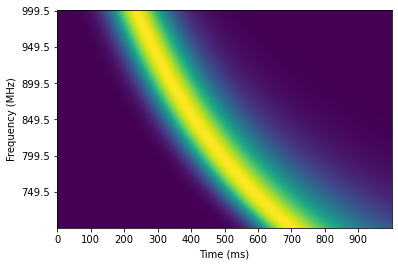

In [3]:
xtick=np.arange(0,fgrid.nsamp,100)
ytick=np.arange(0,fgrid.nchan,50)

plt.imshow(pulse1,aspect='auto')
plt.yticks(np.arange(fgrid.nchan)[ytick],fgrid.vif[ytick])
plt.ylabel('Frequency (MHz)')
plt.xticks(xtick,fgrid.x_time[xtick])
plt.xlabel('Time (ms)')
plt.show()


### ideally you want the nchan to be the same as your real resolution if you are fitting DM, otherwise you will see this kind of chunky block effect. Best solution for fitting is simply dedisperse and set DM to 0. But this is just an example to show what you'll see

In [4]:
fgrid=dynspec.fgrid(fch=1000,nchan=4,tbin=10,fbin=10,tsamp=1,nsamp=500,bwchan=-25)
pulse1=fgrid.pulse(t0=200,width=20,dm=100, A=20,mode='scat',tau=50)
fgrid.fgrid

array([1011.25, 1008.75, 1006.25, 1003.75, 1001.25,  998.75,  996.25,
        993.75,  991.25,  988.75,  986.25,  983.75,  981.25,  978.75,
        976.25,  973.75,  971.25,  968.75,  966.25,  963.75,  961.25,
        958.75,  956.25,  953.75,  951.25,  948.75,  946.25,  943.75,
        941.25,  938.75,  936.25,  933.75,  931.25,  928.75,  926.25,
        923.75,  921.25,  918.75,  916.25,  913.75])

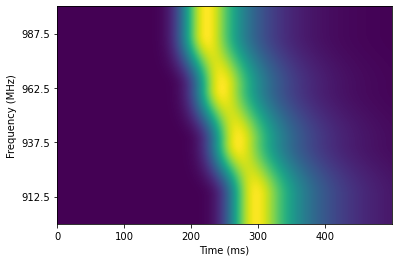

In [5]:
xtick=np.arange(0,fgrid.nsamp,100)
plt.imshow(pulse1,aspect='auto')
plt.yticks(np.arange(fgrid.nchan),fgrid.vif)
plt.ylabel('Frequency (MHz)')
plt.xticks(xtick,fgrid.x_time[xtick])
plt.xlabel('Time (ms)')
plt.show()


## Example for fitting with Bilby

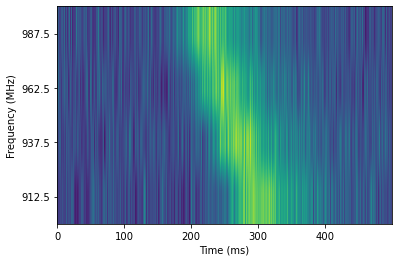

In [6]:
#### Create Mock data

data=pulse1+np.random.randn(fgrid.nchan,fgrid.nsamp)*3
plt.imshow(data,aspect='auto')
plt.yticks(np.arange(fgrid.nchan),fgrid.vif)
plt.ylabel('Frequency (MHz)')
plt.xticks(xtick,fgrid.x_time[xtick])
plt.xlabel('Time (ms)')
plt.show()

In [7]:
#### Write function
# 
# because dynspec is a class, you don't necessarily need an x_input for the data, 
# but you need to pass through the grid object as the x axis
# but if you just want to use bilby, you'll need to make one

### alternatively you can create a tgrid with dynspec.tgrid and fit each channel independently

def model(fgrid,t0=200,width=10,a1=20,a2=20,a3=20,a4=10,tau=10):
    dm=100
    pulse=fgrid.pulse(t0=t0,width=width,dm=dm,A=50,mode='scat',tau=tau)
    rescale=np.transpose(pulse.T/np.max(pulse,1)*np.array([a1,a2,a3,a4]))
    return rescale.flatten()

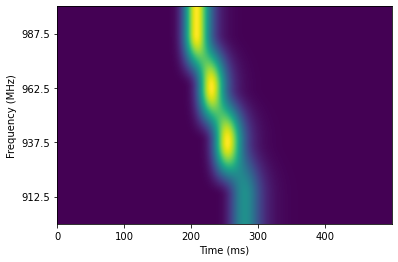

In [8]:
## example of function
pulse1=model(fgrid).reshape(4,500)
plt.imshow(pulse1,aspect='auto')
plt.yticks(np.arange(fgrid.nchan),fgrid.vif)
plt.ylabel('Frequency (MHz)')
plt.xticks(xtick,fgrid.x_time[xtick])
plt.xlabel('Time (ms)')
plt.show()

In [9]:
#### Prep Bilby
o='dynspec_example' ### outdir of bilby
ow=o                #### label of posterior files
# answer is t0=200,width=20,dm=100, A=20,mode='gaussian',tau=50
amin=5
amax=25
taumax=200
priors1 = bilby.core.prior.PriorDict()
# priors1["base"]=bilby.core.prior.Uniform(name='baseline', minimum=-.1,maximum=.1)
priors1["tau"]=bilby.core.prior.Uniform(name='$\\tau$', minimum=40, maximum=60)

priors1["t0"]=bilby.core.prior.Uniform(name='t1', minimum=195,maximum=205)
priors1["width"]=bilby.core.prior.Uniform(name='$\\sigma1$', minimum=18, maximum=22)
priors1["a1"]=bilby.core.prior.Uniform(name='a1', minimum=amin, maximum=amax)
priors1["a2"]=bilby.core.prior.Uniform(name='a2', minimum=amin, maximum=amax)
priors1["a3"]=bilby.core.prior.Uniform(name='a3', minimum=amin, maximum=amax)
priors1["a4"]=bilby.core.prior.Uniform(name='a4', minimum=amin, maximum=amax)
# priors1["a5"]=bilby.core.prior.Uniform(name='a5', minimum=1, maximum=amax)
# priors1["a6"]=bilby.core.prior.Uniform(name='a6', minimum=1, maximum=amax)
### important set sigma unless you have errors ready
priors1["sigma"]=bilby.core.prior.LogUniform(name='error',minimum=0.001,maximum=10)

In [ ]:
likelihood = bilby.core.likelihood.GaussianLikelihood(x=fgrid, y=data.flatten(),func=model, sigma=None)
result = bilby.sampler.run_sampler(likelihood=likelihood, priors=priors1,sampler='dynesty',nlive=512,nwalkers=100,nsteps=5000
                                   ,clean=True,dlogz=0.1,
                                       outdir=o,label=ow,verbose=True,resume=True)

21:48 bilby INFO    : Running for label 'dynspec_example', output will be saved to 'dynspec_example'
21:48 bilby INFO    : Search parameters:
21:48 bilby INFO    :   tau = Uniform(minimum=40, maximum=60, name='$\\tau$', latex_label='$\\tau$', unit=None, boundary=None)
21:48 bilby INFO    :   t0 = Uniform(minimum=195, maximum=205, name='t1', latex_label='t1', unit=None, boundary=None)
21:48 bilby INFO    :   width = Uniform(minimum=18, maximum=22, name='$\\sigma1$', latex_label='$\\sigma1$', unit=None, boundary=None)
21:48 bilby INFO    :   a1 = Uniform(minimum=5, maximum=25, name='a1', latex_label='a1', unit=None, boundary=None)
21:48 bilby INFO    :   a2 = Uniform(minimum=5, maximum=25, name='a2', latex_label='a2', unit=None, boundary=None)
21:48 bilby INFO    :   a3 = Uniform(minimum=5, maximum=25, name='a3', latex_label='a3', unit=None, boundary=None)
21:48 bilby INFO    :   a4 = Uniform(minimum=5, maximum=25, name='a4', latex_label='a4', unit=None, boundary=None)
21:48 bilby INFO  

0it [00:00, ?it/s]

21:48 bilby WARNING : Supplied argument 'nwalkers' not an argument of 'Dynesty', removing.
21:48 bilby WARNING : Supplied argument 'nsteps' not an argument of 'Dynesty', removing.
21:48 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 512, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 307, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f93fb8ebb90>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact'

In [ ]:
result.plot_corner(parameters=['t1','tau','width','a1','a2','a3','a4','sigma'],
                   priors=priors1,filename=f'{o}/{ow}_corner.pdf',
                  save=True)